In [28]:
# Other libraries
import pandas as pd
import numpy as np
import glob

In [1]:
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio
from rasterio.transform import xy

In [2]:
PathToGeoTiffFile = "Potsdam-GeoTif"
blob = PathToGeoTiffFile +  '/0000000672-0000033824.tif'

In [3]:
img = rio.open(blob)
img_array = img.read()
imtransform = img.transform
nRows = img_array.shape[1]
ncols = img_array.shape[2]
Bands = img_array.shape[0]

img_array = img_array.reshape(Bands, nRows*ncols).T
img_array = img_array.reshape( nRows,ncols, Bands)

Text(0.5, 1.0, 'Input image')

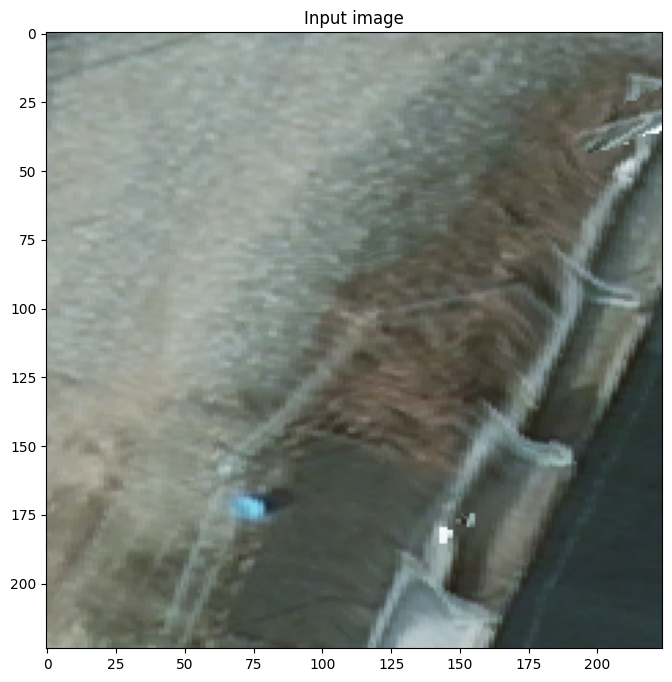

In [4]:
plt.figure(figsize=(24,8))

plt.imshow(img_array[:,:,0:3]/255)
plt.title('Input image')


In [5]:
from rasterio.transform import xy

with rio.open(blob) as dataset:
    width, height = dataset.width, dataset.height
    center_x = width // 2
    center_y = height // 2
    lon, lat = xy(dataset.transform, center_y, center_x)

print(f"Center Longitude: {lon}, Center Latitude: {lat}")

Center Longitude: 13.046746932189148, Center Latitude: 52.41083329993581


In [5]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Open the image file
with rasterio.open(blob) as src:
    # Read the bands
    red = src.read(1)  # Red band
    green = src.read(2)  # Green band
    blue = src.read(3)  # Blue band
    infrared = src.read(4)  # Infrared band
    elevation = src.read(5)  # Elevation band
    target = src.read(6)  # Target label band

# Create RGB composite
rgb = np.stack([red, green, blue], axis=-1)
rgb_normalized = (rgb / rgb.max() * 255).astype(np.uint8)  # Normalize to 8-bit

# Prepare figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RGB Visualization
axes[0].imshow(rgb_normalized)
axes[0].set_title('RGB', fontsize=12)
axes[0].axis('off')

# Elevation Visualization
elevation = elevation.squeeze()
elev_plot = axes[1].imshow(elevation, cmap='terrain')
plt.colorbar(elev_plot, ax=axes[1], label='Elevation (meters)')
axes[1].set_title('Elevation Band', fontsize=12)
axes[1].axis('off')

# Target Label Visualization
target = target.squeeze().astype(int)
unique_labels = np.unique(target)
num_classes = len(unique_labels)

# Class names and colors (all six classes)
class_names = ['Impervious surface', 'Building', 'Tree', 'Low vegetation', 'Car', 'Clutter/Background']
colors = ['gray', 'red', 'green', 'lightgreen', 'blue', 'black']

# Create discrete colormap for all six classes
cmap = ListedColormap(colors)
bounds = np.arange(len(class_names) + 1) - 0.5  # Use len(class_names) instead of num_classes
norm = BoundaryNorm(bounds, cmap.N)

# Plot the target labels
label_plot = axes[2].imshow(target, cmap=cmap, norm=norm)

# Create colorbar with all six classes
cbar = plt.colorbar(label_plot, ax=axes[2], ticks=np.arange(len(class_names)))
cbar.set_ticklabels(class_names)
axes[2].set_title('Target Label', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'blob' is not defined

In [7]:
import os
import random
from sklearn.model_selection import KFold
from shutil import copyfile

# Path to the directory containing GeoTIFF files
PathToGeoTiffFile = "Potsdam-GeoTif"

# Output folder for 5-fold splits
output_folder = "Potsdam-5Fold-Splits"
os.makedirs(output_folder, exist_ok=True)

# Step 1: Read all GeoTIFF file paths
all_files = [os.path.join(PathToGeoTiffFile, f) for f in os.listdir(PathToGeoTiffFile) if f.endswith(".tif")]

# Step 2: Randomly sample at least 10,000 images
random.seed(42)  # Ensure reproducibility
sampled_files = random.sample(all_files, 10000)  # Extract 10,000 samples

# Step 3: Split into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (_, fold_idx) in enumerate(kf.split(sampled_files)):
    fold_folder = os.path.join(output_folder, f"fold_{fold}")
    os.makedirs(fold_folder, exist_ok=True)

    # Copy files for this fold
    for idx in fold_idx:
        src = sampled_files[idx]
        dst = os.path.join(fold_folder, os.path.basename(src))
        copyfile(src, dst)

    print(f"Fold {fold} prepared: {len(fold_idx)} files")

print(f"5-Fold splits saved in: {output_folder}")

Fold 0 prepared: 2000 files
Fold 1 prepared: 2000 files
Fold 2 prepared: 2000 files
Fold 3 prepared: 2000 files
Fold 4 prepared: 2000 files
5-Fold splits saved in: Potsdam-5Fold-Splits


In [8]:
len(all_files)

15048

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class
class PotsdamDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.file_list = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.file_list[idx])
        with rasterio.open(img_path) as src:
            img = src.read()
            img = np.transpose(img, (1, 2, 0))  # Change to (H, W, C)
            label = img[:, :, -1]  # Assuming the last band is the label
            img = img[:, :, :-1]  # Remove the label band from the image

        if self.transform:
            img = self.transform(img)

        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # Change to (C, H, W)
        label = torch.tensor(label, dtype=torch.long)
        return img, label

# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 6, kernel_size=3, padding='same')
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.softmax(x)
        return x

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
])

# Load datasets
train_folders = ['Potsdam-5Fold-Splits/fold_0', 'Potsdam-5Fold-Splits/fold_1', 'Potsdam-5Fold-Splits/fold_2']
train_datasets = [PotsdamDataset(folder, transform=transform) for folder in train_folders]
train_dataset = ConcatDataset(train_datasets)

val_dataset = PotsdamDataset('Potsdam-5Fold-Splits/fold_3')
test_dataset = PotsdamDataset('Potsdam-5Fold-Splits/fold_4')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

  0%|          | 0/750 [00:00<?, ?it/s]


RasterioIOError: 'Potsdam-5Fold-Splits/fold_2/0000020832-0000039424.tif' not recognized as being in a supported file format.

NameError: name 'img_path' is not defined

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PotsdamDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.file_list = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.file_list[idx])
        with rasterio.open(img_path) as src:
            img = src.read()  # (C, H, W)

        label = img[-1, :, :]  # (H, W)
        img = img[0:4, :, :]   # (4, H, W)

        # 转换为 (H, W, C) 以适应 ToTensor()
        img = np.transpose(img, (1, 2, 0))  # (H, W, 4)

        if self.transform:
            img = self.transform(img)  # ToTensor() 转换为 (4, H, W)
        else:
            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)

        label = torch.tensor(label, dtype=torch.long)
        return img, label

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 6, kernel_size=3, padding='same')
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.softmax(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
])

from torch.utils.data import DataLoader, ConcatDataset

# 合并数据集
train_folders = [
    'Potsdam-5Fold-Splits/fold_0',
    'Potsdam-5Fold-Splits/fold_1',
    'Potsdam-5Fold-Splits/fold_2'
]
train_datasets = [PotsdamDataset(folder, transform=transform) for folder in train_folders]
train_dataset = ConcatDataset(train_datasets)

# 创建 DataLoader，设置 shuffle=True
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)
val_dataset = PotsdamDataset('Potsdam-5Fold-Splits/fold_3', transform=transform)
test_dataset = PotsdamDataset('Potsdam-5Fold-Splits/fold_4', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 验证输入形状
for inputs, labels in train_loader:
    print("修正后输入形状:", inputs.shape)  # [8, 4, 224, 224]
    print("修正后标签形状:", labels.shape)  # [8, 224, 224]
    break

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.numel()
            correct_train += (predicted == labels).sum().item()
            print(labels.numel()==labels.size(1)*labels.size(2)*8)


        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.numel()
                correct_val += (predicted == labels).sum().item()


        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

RasterioIOError: 'Potsdam-5Fold-Splits/fold_2/0000002912-0000032928.tif' not recognized as being in a supported file format.